In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!unzip -qq /content/usg1_dataset.zip -d /content

In [3]:
train = pd.read_csv('usg1_dataset/train.csv')

train.shape

(12716, 2)

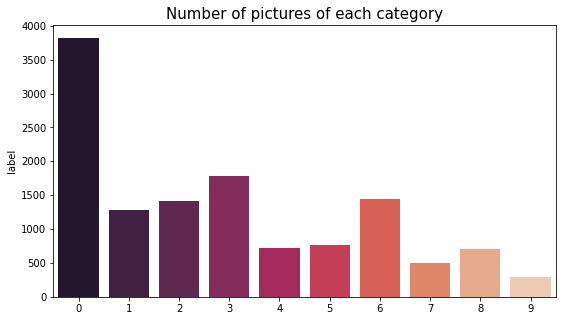

In [4]:
vc = train['label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

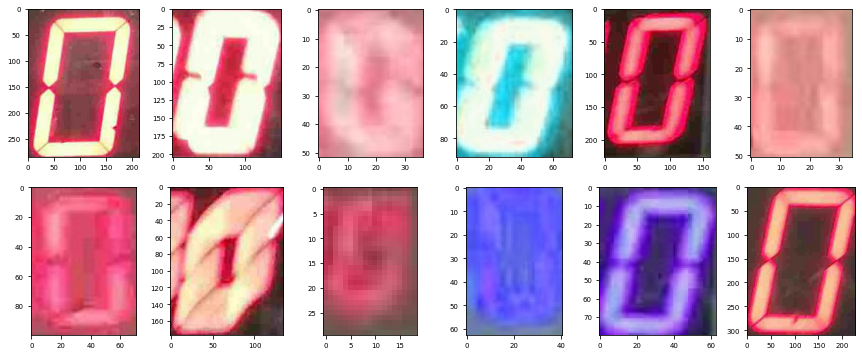

In [5]:
# 이미지 데이터 출력
import matplotlib.gridspec as gridspec
import cv2

plt.rc('font', size=7)
plt.figure(figsize=(15,6)) # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치 (2행 6열)

# 숫자0 이미지 파일명(마지막 12개)
last_has_zero_img_name = train[train['label']==0]['image_name'][-12:]

# 이미지 출력
for idx, img_name in enumerate(last_has_zero_img_name):
    img_path = 'usg1_dataset/train_images/' + img_name
    image = cv2.imread(img_path)                   # 이미지 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력

In [6]:
import torch
import random
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                               # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)                            # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)                         # 파이토치 난수 생성기 시드 고정 (GPU 사용시)
torch.cuda.manual_seed(seed)                    # 파이토치 난수 생성기 시드 고정 (GPU 사용시)
torch.cuda.manual_seed_all(seed)                # 파이토치 난수 생성기 시드 고정 (멀티 GPU사용시)
torch.backends.cudnn.deterministic = True       # 확정적 연산 사용
torch.backends.cudnn.benchmark = False          # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False            # cudnn 사용 해제

# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

labels = pd.read_csv('usg1_dataset/train.csv')
  
# 훈련 데이터, 검증 데이터 분리
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels,
                               test_size = 0.1,
                               random_state=50)

In [7]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__()
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    # 데이터셋 크기 반환 메서드(오버라이딩)
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드(오버라이딩)
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label   

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(256, 256),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),                                
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),         # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3),       # 어파인 변환
    A.Normalize(),                  # 정규화(픽셀값 범위 동일하게) 변환
    ToTensorV2()                    # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),                  # 정규화 변환
    ToTensorV2()
])

In [16]:
#데이터셋 및 데이터 로더 생성
img_dir = 'usg1_dataset/train_images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

# 멀티프로세싱을 위한 데이터 로더의 시드값 고정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# 데이터 로더
from torch.utils.data import DataLoader

batch_size = 32

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                          worker_init_fn=seed_worker, generator=g, num_workers=4)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False,
                          worker_init_fn=seed_worker, generator=g, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
import torch.nn as nn
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_loaded = torchvision.models.efficientnet_b0(weights=weights)

model_loaded.classifier = torch.nn.Sequential(
    nn.Dropout(0.2, inplace=True), 
    nn.Linear(in_features=1280,
              out_features=10)
)

print(model_loaded.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


In [18]:
model = model_loaded.to(device)

In [19]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 모델훈련

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.5 MB/s eta 0:00:00


In [20]:
import torch.nn as nn

# 손실 함수 설정
criterion = nn.CrossEntropyLoss()
# 옵티마이저 설정 : 최적 가중치 찾아주는 알고리즘
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001) #lr : learning rate

In [21]:
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup

# 모델 훈련
epochs = 40

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

torch.cuda.empty_cache()    
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    # training loop
    running_loss = 0       
    running_accuracy = 0 
    model.train()
    for _, data in enumerate(tqdm(loader_train)):
        # training phase            
        images, labels = data
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        
        # 순전파(forward) : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels) # 손실 함수를 활용해 output와 labels의 손실값 계산            

        # backward
        running_loss += loss.item() # 역전파 수행
        running_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/images.size(0)
        loss.backward()
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
    
    # validation loop
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for _, data in enumerate(tqdm(loader_valid)):                
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # evaluation metrics
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/images.size(0)

    # calculate mean for each batch
    train_losses.append(running_loss / len(loader_train))
    val_losses.append(val_loss / len(loader_valid))
    train_acc.append(running_accuracy / len(loader_train))
    val_acc.append(val_accuracy / len(loader_valid))
    print("Epoch:{}/{}..".format(epoch + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(loader_train)),
            "Val Loss: {:.3f}..".format(val_loss / len(loader_valid)),
            "Train Acc:{:.3f}..".format(running_accuracy / len(loader_train)),
            "Val Acc:{:.3f}..".format(val_accuracy / len(loader_valid)))

history = {'train_loss': train_losses, 'val_loss': val_losses,
            'train_acc': train_acc, 'val_acc': val_acc}

 11%|█         | 39/358 [00:52<07:08,  1.34s/it]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import f1_score

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정

with torch.no_grad(): # 기울기 계산 비 활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.max(outputs.cpu(), 1)
        true = labels.cpu()

        # 예측 확률과 실젯값을 리스트에 추가
        preds_list.extend(preds.indices)
        true_list.extend(true)

# 검증 데이터 점수 계산.
print(f1_score(preds_list, true_list, average = "macro")